In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import json

In [8]:
def load_sweep(path: str) -> pd.DataFrame:
    with open(path) as f:
        return pd.DataFrame.from_dict(
            dict(**line, **result)
            for line in filter(lambda d: "results" in d, map(json.loads, f))
            for result in line["results"]
        ).drop(columns=["results", "_duration"])


pd.concat([load_sweep(f) for f in Path("data").glob("*.jsonl")]).reset_index(
    drop=True
).drop(columns=["id", "output", "local_ratio", "prefill_length"]).groupby(
    ["dataset", "shots", "model_scale", "k", "cluster_evicted", "cluster_weight"], dropna=False
).mean().reset_index().to_json(
    "summary.jsonl",
    orient="records",
    lines=True
)


In [9]:
df = pd.read_json("summary.jsonl", lines=True)

In [10]:
df

,dataset,shots,model_scale,k,cluster_evicted,cluster_weight,match
0,squad,1,1b,128,False,NaN,0.1175
1,squad,1,1b,128,True,0.25,0.1000
2,squad,1,1b,128,True,0.50,0.0850
3,squad,1,1b,128,True,0.75,0.0800
4,squad,1,1b,128,True,0.90,0.0725
5,squad,1,1b,256,False,NaN,0.1425
6,squad,1,1b,256,True,0.25,0.1200
7,squad,1,1b,256,True,0.50,0.1150
8,squad,1,1b,256,True,0.75,0.1125
9,squad,1,1b,256,True,0.90,0.1050


In [11]:
df_cluster = df[df["cluster_evicted"] == True]
df_eviction = df[df["cluster_evicted"] == False]

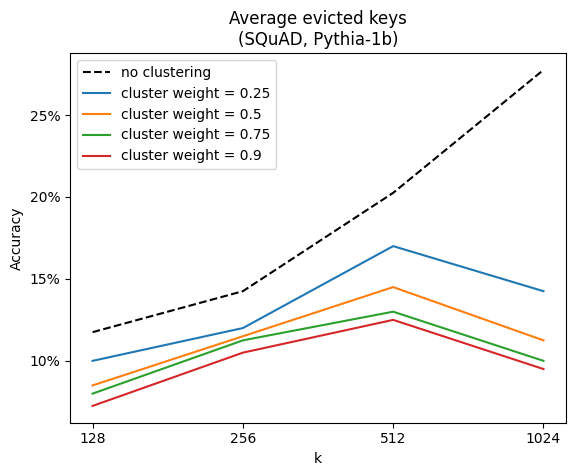

In [12]:
# Baseline
ax = plt.subplot()
ax.plot(df_eviction["k"], df_eviction["match"], color="black", linestyle="--", label="no clustering")

# Clustering
grouped = df_cluster.groupby("cluster_weight")
for c_weight, g in grouped:
    ax.plot(g["k"], g["match"], label=f"cluster weight = {c_weight}")

ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.legend(loc="upper left", fontsize=10)
plt.title("Average evicted keys\n(SQuAD, Pythia-1b)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()